In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

import numpy as np
import os, random
from itertools import chain
from utils import *
from cycleGAN import *

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
torch.set_num_threads(4)

In [4]:
# load data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainX= torchvision.datasets.ImageFolder('/home/dayun/data/horse2zebra/trainA/', transform=transform)
trainX_loader = data.DataLoader(trainX, batch_size=1, num_workers = 4, shuffle=True)

trainY= torchvision.datasets.ImageFolder('/home/dayun/data/horse2zebra/trainB/', transform=transform)
trainY_loader = data.DataLoader(trainY, batch_size=1, num_workers = 4, shuffle=True)

print(len(trainX_loader), len(trainY_loader))

1067 1334


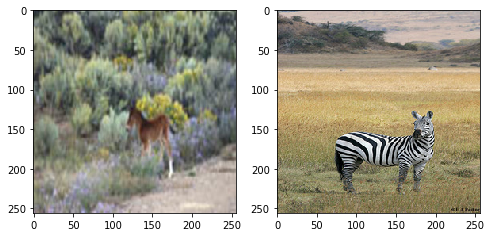

torch.Size([1, 3, 256, 256])


In [5]:
#check data
dataiterX = iter(trainX_loader)
imageX, _ = dataiterX.next()

dataiterY = iter(trainY_loader)
imageY, _ = dataiterY.next()

imshow(imageX, imageY)
print(imageX.shape)

In [6]:
# make models and optimizer
Lambda = 10
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    cudnn.benchmark = True     
    
G = Generator(num_res = 9).to(device)  # x->y
F = Generator(num_res = 9).to(device)   # y->x
Dx = Discriminator().to(device)
Dy = Discriminator().to(device)

models = [G, F, Dx, Dy]
for model in models:
    model.apply(weights_init)
    model.to(device)

MSE = nn.MSELoss()
L1 = nn.L1Loss()

optim_G = optim.Adam(chain(G.parameters(),F.parameters()), lr=0.0002)
optim_D = optim.Adam(chain(Dx.parameters(),Dy.parameters()), lr=0.0002)

scheduler_G = optim.lr_scheduler.LambdaLR(optim_G, lr_lambda = decayLR)
scheduler_D = optim.lr_scheduler.LambdaLR(optim_D, lr_lambda = decayLR)

In [ ]:
BUFFER = {'x': [],
          'y': []}

for epoch in range(200):
    for i, (x, y) in enumerate(zip(trainX_loader, trainY_loader)):
        ## generator
        
        for p in chain(Dx.parameters(),Dy.parameters()):
            p.requires_grad = False
        
        optim_G.zero_grad()
        
        # x -> y -> x
        x_real = x[0].to(device).requires_grad_(True)
        y_fake = G(x_real)
        x_re = F(y_fake)

        # y -> x -> y
        y_real = y[0].to(device).requires_grad_(True)
        x_fake = F(y_real)
        y_re = G(x_fake) 
        
        # adversarial loss
        Dy_dis = Dy(y_fake)
        Dx_dis = Dx(x_fake)
        
        loss_GAN_x = MSE(Dy_dis, torch.ones(Dy_dis.size(), device = device, requires_grad = True))
        loss_GAN_y = MSE(Dx_dis, torch.ones(Dx_dis.size(), device = device, requires_grad = True))
        
        # cycle consistenct loss
        loss_cyc_x = L1(x_re, x_real)
        loss_cyc_y = L1(y_re, y_real)
        
        # backward
        loss_G = loss_GAN_x + loss_GAN_y + Lambda * (loss_cyc_x + loss_cyc_y)
        loss_G.backward()

        ## discriminator
        for p in chain(Dx.parameters(),Dy.parameters()):
            p.requires_grad = True
        
        optim_D.zero_grad()
         
        # buffer
        x_fake2 = torch.from_numpy(buffer(BUFFER['x'], F(y_real).cpu().detach().numpy())).to(device).requires_grad_(True)
        y_fake2 = torch.from_numpy(buffer(BUFFER['y'], G(x_real).cpu().detach().numpy())).to(device).requires_grad_(True)
        
        # Dy
        Dy_real = Dy(y_real)
        Dy_fake = Dy(y_fake2)
        
        loss_Dy_real = MSE(Dy_real, torch.ones(Dy_real.size(), device = device, requires_grad = True))
        loss_Dy_fake = MSE(Dy_fake, torch.zeros(Dy_fake.size(), device = device, requires_grad = True))
        loss_Dy = loss_Dy_real + loss_Dy_fake
        
        # Dx
        Dx_real = Dx(x_real)
        Dx_fake = Dx(x_fake2)
        
        loss_Dx_real = MSE(Dx_real, torch.ones(Dx_real.size(), device = device, requires_grad = True))
        loss_Dx_fake = MSE(Dx_fake, torch.zeros(Dx_fake.size(), device = device, requires_grad = True))
        loss_Dx = loss_Dx_real + loss_Dx_fake
        
        loss_D = (loss_Dy + loss_Dx) * 0.5
        loss_D.backward()
        
        optim_G.step()
        optim_D.step()
        
    print("#### epoch:%d" %epoch)
    imshow(x_real, y_fake)
    imshow(y_real, x_fake)
        
    scheduler_G.step()    
    scheduler_D.step()    
    
    save_model(G, F, Dx, Dy, '1_HZ')
    save_dict(BUFFER, '1_HZ_BUFFER')    

# Test

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testX= torchvision.datasets.ImageFolder('/home/dayun/data/horse2zebra/testA/', transform=transform)
testX_loader = data.DataLoader(testX, batch_size=1, num_workers = 4, shuffle=False)

testY= torchvision.datasets.ImageFolder('/home/dayun/data/horse2zebra/testB/', transform=transform)
testY_loader = data.DataLoader(testY, batch_size=1, num_workers = 4, shuffle=False)

In [21]:
if not os.path.exists('IMG/exp1/'):
    os.makedirs('IMG/exp1/')
    os.makedirs('IMG/exp1/horse2zebra')
    os.makedirs('IMG/exp1/zebra2horse')
    
for i, (image, _) in enumerate(testX_loader, 0):
    x_real = image.to(device)
    y_fake = G(x_real)
    
    fname, _ = testX_loader.dataset.samples[i]
    fid = fname.split('/')[7].split('_')[1][:-4]
    y_fake = y_fake.mul(0.5).add(0.5)  # denormalize
    y_fake = y_fake.data.cpu()
    torchvision.utils.save_image(y_fake, 'IMG/exp1/fake_{}.png'.format(str(fid)))
    
for i, (image, _) in enumerate(testY_loader, 0):
    y_real = image.to(device)
    x_fake = F(y_real)
    
    fname, _ = testY_loader.dataset.samples[i]
    fid = fname.split('/')[7].split('_')[1][:-4]
    x_fake = x_fake.mul(0.5).add(0.5)  # denormalize
    x_fake = x_fake.data.cpu()
    torchvision.utils.save_image(x_fake, 'IMG/exp1/zebra2horse/fake_{}.png'.format(str(fid)))